#  &#x1F4D1; **作业 14: 终生机器学习 `LifeLong Machine Learning`**
### 助教的PPT
[PPT](https://docs.google.com/presentation/d/1SMJLWPTPCIrZdNdAjrS4zQZx1kfB73jCFSb7JRX90gQ/edit?usp=sharing)

- 终生学习的定义
  - 关于终身学习的详细解释和定义，请参阅 [LifeLong learning | youtu.be](https://youtu.be/7qT5P9KJnWo) 

- 终生学习的一些方法
  - 有人在2019年底为LifeLong Learning提出了一份调查论文，将2016-2019年的LigeLong学习方法分为三个家族。
依据任务数据信息在整个学习过程中的存储和使用方式的差异，可以将LifeLong学习方法分为三类：
    * 基于重采样的方法   `Replay-based methods`
    * 基于正则化的方法  `Regularization-based methods`
    * 参数隔离方法      `Parameter isolation methods`

![LL_summary](./HW14_pic/LLL_summary.png)

在本次作业中，我们关注**基于正则化的方法**中的`prior-focused`方法: **EWC、MAS、SI、Remanian Walk、SCP**



论文: [Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf)

如果您有任何问题，请随时给我们发邮件。[ntu-ml-2022spring-ta@googlegroups.com](ntu-ml-2022spring-ta@googlegroups.com)

# 导入包

In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import random

In [2]:
!nvidia-smi

Wed Jul 19 13:19:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def all_seed(seed=6666, env=None):
    if env is not None:
        env.seed(seed)
        env.action_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')

all_seed(0)

Set env random_seed = 0


# 数据准备

我们使用旋转的手写识别数据集MNIST(`rotated MNIST`) 作为训练集  
因此，我们使用5种不同的旋转来生成5种不同的MNIST作为不同的任务

## 数据旋转与转换

In [4]:
# 旋转 MNIST 数据生成 5 个任务
def _rotate_image(image, angle):
    if angle is None:
        return image
    image = transforms.functional.rotate(image, angle=angle)
    return image


def get_transform(angle=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
       transforms.Lambda(lambda x: _rotate_image(x, angle)),
       Pad(28)
    ])
    return transform


class Pad(object):
    def __init__(self, size, fill=0, padding_mode='constant'):
        self.size = size
        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img):
        # 输入图片的长宽是一致的，如果输入图片的size比期望的size小时，对图片的四周进行扩充
        img_size = img.size()[1]
        assert ((self.size - img_size) % 2 == 0)
        padding = (self.size - img_size) // 2
        padding = (padding, padding, padding, padding)
        return F.pad(img, padding, self.padding_mode, self.fill)

    
class Data():
    def __init__(self, path, train=True, angle=None):
        transform = get_transform(angle)
        self.dataset = datasets.MNIST(root=os.path.join(path, "MNIST"), transform=transform, train=train, download=True)

## 构建Dataloaders数据及训练参数
- 一些训练参数
  - 设置 5 个不同的旋转
  - 5 Train DataLoader
  - 5 Test DataLoader 

In [5]:
class Args:
    task_number = 5
    epochs_per_task = 10
    lr = 1.0e-4
    batch_size = 128
    test_size=8192

args=Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 给每个task 生成旋转角度.
angle_list = [20 * x for x in range(args.task_number)]
# 准备5个Task: 不同旋转角度的 MNIST 数据集.
train_datasets = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]
train_dataloaders = [DataLoader(data.dataset, batch_size=args.batch_size, shuffle=True) for data in train_datasets]

test_datasets = [Data('data', train=False, angle=angle_list[index]) for index in range(args.task_number)]
test_dataloaders = [DataLoader(data.dataset, batch_size=args.test_size, shuffle=True) for data in test_datasets]

100%|██████████| 9912422/9912422 [00:00<00:00, 104073793.49it/s]

Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40031623.87it/s]


Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 131303590.15it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8690934.66it/s]


Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



### 可视化

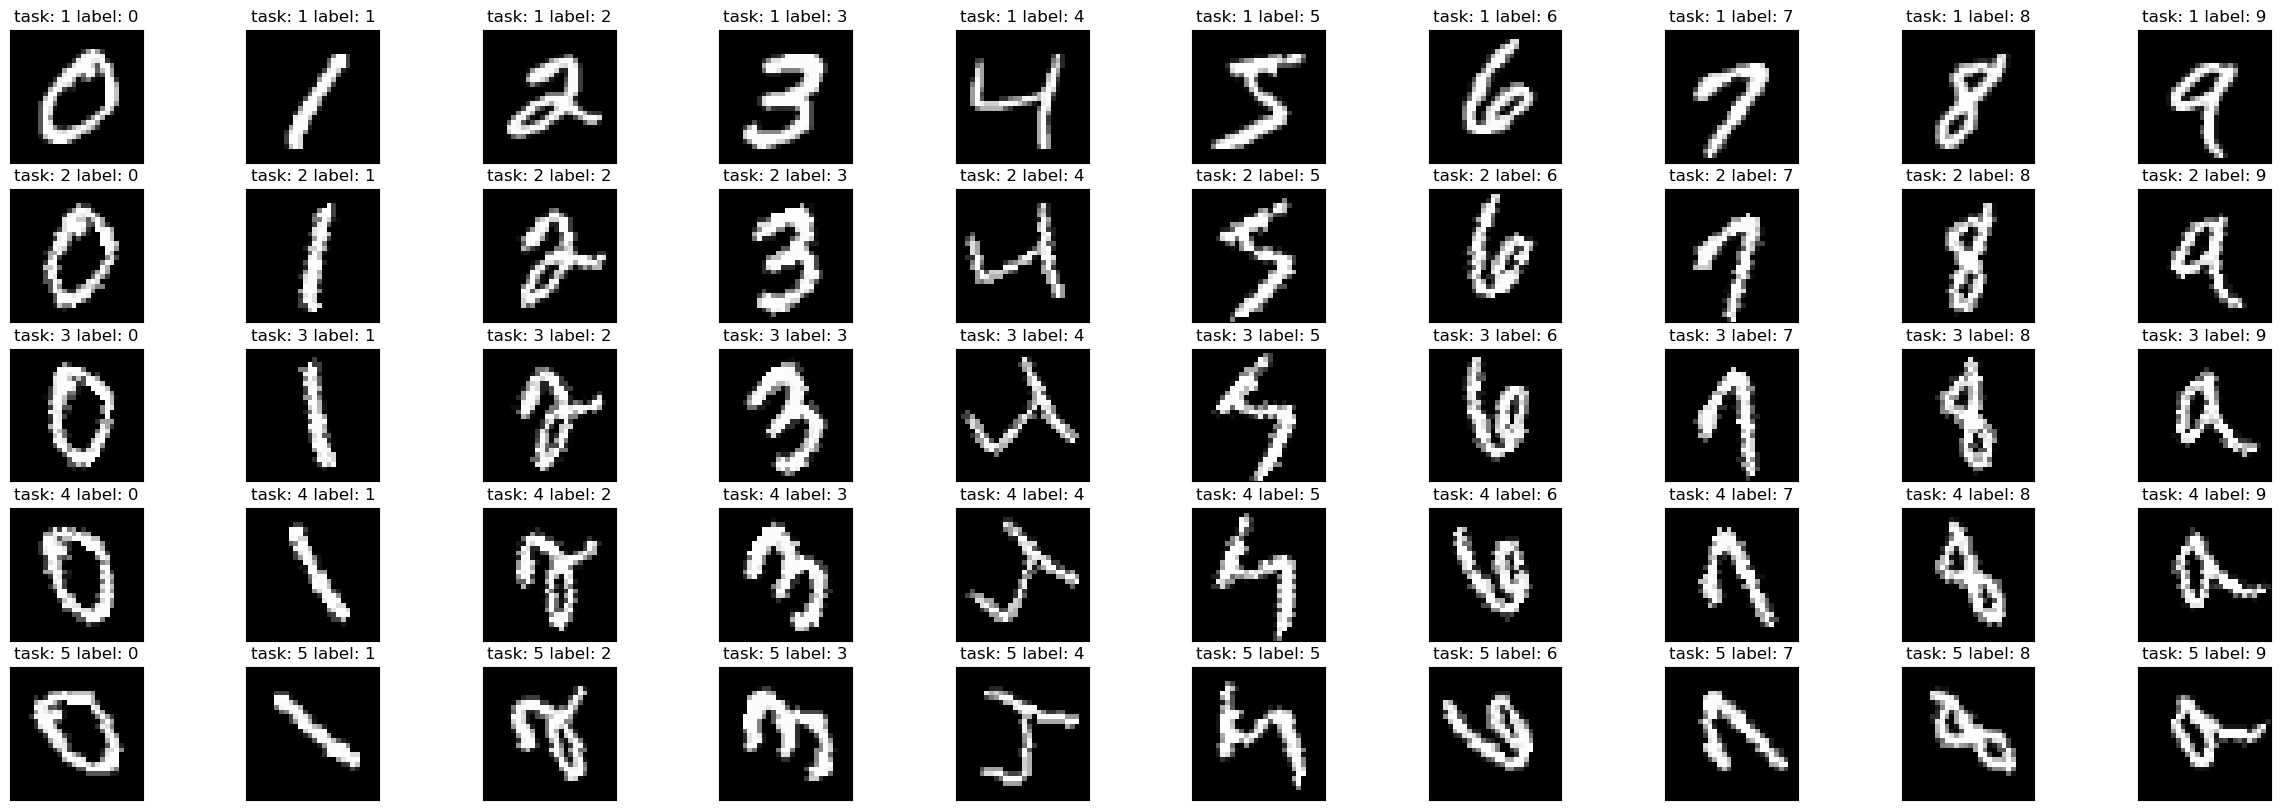

In [6]:
# 分别绘制5个任务中的0-9图像
sample = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]

plt.figure(figsize=(30, 10))
for task in range(5):
    target_list = []
    cnt = 0
    while (len(target_list) < 10):
        img, target = sample[task].dataset[cnt]
        cnt += 1
        if target in target_list:
            continue
        else:
            target_list.append(target)
        plt.subplot(5, 10, (task)*10 + target + 1)
        curr_img = np.reshape(img, (28, 28))
        plt.matshow(curr_img, cmap=plt.get_cmap('gray'), fignum=False)
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        plt.title("task: " + str(task+1) + " " + "label: " + str(target), y=1)

# 模型准备 
## 模型架构

为了公平地比较，采用同一模型进行序列任务连续训练，该模型体系结构由4层全连接层组成。

In [7]:
class Model(nn.Module):
    """
    模型架构
    1*28*28 (input) → 1024 → 512 → 256 → 10
    """
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1*28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 1*28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x


example = Model()
print(example)

Model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


# 训练与评估

## 模型训练
以下是我们模型训练的fuction，能同样适用于本次作业中不同的终身学习算法（基于正则化）的训练

In [8]:
def train(model, optimizer, dataloader, epochs_per_task, lll_object, lll_lambda, test_dataloaders, evaluate, device, log_step=1):
    model.train()
    model.zero_grad()
    objective = nn.CrossEntropyLoss()
    acc_per_epoch = []
    loss = 1.0
    for epoch in range(epochs_per_task):
        tr_bar = tqdm(dataloader, leave=False)
        for imgs, labels in  tr_bar: 
            tr_bar.set_description(f"[ Train | Epoch {epoch+1:02d}/{epochs_per_task:02d} ]")
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = objective(outputs, labels)
            total_loss = loss
            # ----------  正则化 ----------
            lll_loss = lll_object.penalty(model)
            total_loss += lll_lambda * lll_loss 
            # model update
            lll_object.update(model)
            # ----------------------------
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            loss = total_loss.item()
            tr_bar.set_postfix({"Loss": f"{loss:.7f}"})

        acc_average  = []
        for test_dataloader in test_dataloaders: 
            acc_test = evaluate(model, test_dataloader, device)
            acc_average.append(acc_test)
        average = np.mean(np.array(acc_average))
        acc_per_epoch.append(average*100.0)
        print(f"[ Val | Epoch {epoch+1:02d}/{epochs_per_task:02d} ] acc={average*100:.3f} %")
    return model, optimizer, acc_per_epoch

## 模型评估
以下是我们模型评估的fuction，能同样适用于本次作业中不同的终身学习算法（基于正则化）的评估


In [9]:
def evaluate(model, test_dataloader, device):
    model.eval()
    correct_cnt = 0
    total = 0
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, pred_label = torch.max(outputs.data, 1)

        correct_cnt += (pred_label == labels.data).sum().item()
        total += torch.ones_like(labels.data).sum().item()
    return correct_cnt / total

# &#x2728; 终生学习——基于正则化的`prior-focused`方法
- Baseline
- EWC
- SI
- MAS
- RWalk
- SCP

In [10]:
class baseline(object):
    """
    基准`baseline`方法 : 不做正则化 [ 初始化权重矩阵全为0 ]
    """
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        # 提取模型中的所有参数
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
        # 保存当前参数
        self.p_old = {} 
        # 生成权重矩阵-全都为0
        self._precision_matrices = self._calculate_importance()  
        for n, p in self.params.items():
            # 将原始参数保存在 p_old 中- 保存为不可导
            self.p_old[n] = p.clone().detach() 

    def _calculate_importance(self):
        precision_matrices = {} 
        # 初始化权重（fill zero）
        for n, p in self.params.items(): 
            precision_matrices[n] = p.clone().detach().fill_(0)

        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
            loss += _loss.sum()
        return loss

    def update(self, model):
        # do nothing
        return

In [12]:
# Baseline
print("RUN BASELINE")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=baseline(model=model, dataloader=None, device=device)
lll_lambda=0.0
baseline_acc=[]
task_bar = tqdm(range(len(train_dataloaders)))

# 不断地对每项任务进行迭代训练
for train_indexes in task_bar:
    task_bar.set_description(f"Task  {train_indexes+1:02d}")
    print(f'train_indexes={train_indexes}\n', '--'*25)
    # 训练每个任务
    model, _, acc_list = train(
        model, optimizer, train_dataloaders[train_indexes], 
        args.epochs_per_task, 
        lll_object, lll_lambda, 
        evaluate=evaluate,
        device=device, 
        # 评估 所有训练过的task对应的test数据
        test_dataloaders=test_dataloaders[:train_indexes+1])

    # 获取模型权重（对于baseline 实际无任何变化） 
    lll_object=baseline(model=model, dataloader=train_dataloaders[train_indexes],device=device)
    # 使用新的优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # 收集每个epoch的平均精度
    baseline_acc.extend(acc_list)


print(baseline_acc)
print("==================================================================================================")

RUN BASELINE


  0%|          | 0/5 [00:00<?, ?it/s]

train_indexes=0
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=92.550 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=94.600 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.760 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.180 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=97.160 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=97.400 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=97.490 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=97.670 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=97.460 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=97.980 %
train_indexes=1
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=95.620 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=95.795 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.510 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=95.610 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=95.425 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=95.600 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=95.155 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=95.320 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=95.145 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=95.545 %
train_indexes=2
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=91.120 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=89.743 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=89.443 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=89.493 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=87.483 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=88.507 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=88.177 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=87.470 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=87.790 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=86.427 %
train_indexes=3
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=82.305 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=79.635 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=79.445 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=79.095 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=79.532 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=78.125 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=78.527 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=79.185 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=77.377 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=77.732 %
train_indexes=4
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=75.250 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=73.334 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=72.194 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=72.112 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=71.668 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=70.198 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=71.178 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=70.718 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=70.052 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=69.880 %
[92.55, 94.6, 95.76, 96.17999999999999, 97.16, 97.39999999999999, 97.49, 97.67, 97.46000000000001, 97.98, 95.61999999999999, 95.795, 95.51, 95.61, 95.42500000000001, 95.6, 95.155, 95.32000000000001, 95.145, 95.54499999999999, 91.12, 89.74333333333333, 89.44333333333333, 89.49333333333334, 87.48333333333332, 88.50666666666667, 88.17666666666666, 87.47, 87.79, 86.42666666666666, 82.30499999999999, 79.63499999999999, 79.445, 79.095, 79.5325, 78.125, 78.52749999999999, 79.18499999999999, 77.3775, 77.73249999999999, 75.25, 73.334, 72.194, 72.112, 71.66799999999999, 70.19800000000001, 71.178, 70.718, 70.05199999999999, 69.88000000000001]


## &#x2728;  EWC
> 输入 新task的训练数据和`label`

弹性权重合并(`Elastic Weight Consolidation`)

`ewc` 类中实现了`EWC`算法去计算正则项。这个核心概念可以看李宏毅老师的课程。这里我们将重点讨论EWC的算法。  
在这项作业中，我们想让我们的模型依次学习10项任务。这里我们展示了一个简单的例子，让模型依次学习2个任务（任务a和任务B）。

在 EWC 算法中, 损失函数定义如下:
 $$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_{i} - \theta_{A,i}^{*})^2  $$
  
假设我们有一个具有两个以上参数的神经网络。 $F_i$对应于李宏毅教授讲座中的$i^{th}$守卫. 请不要修改此参数，因为它对任务A很重要。

$F$定义如下:  **即梯度的平方**
$$ F = [ \nabla \log(p(y_n | x_n, \theta_{A}^{*})) \nabla \log(p(y_n | x_n, \theta_{A}^{*}))^T ] $$ 

我们只取矩阵的对角线值来近似每个参数的$F_i$.

详细信息和推导在[Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf) 中 2.4.1 and 2.4 

参考论文: [Elastic Weight Consolidation](https://arxiv.org/pdf/1612.00796.pdf)

In [13]:
class ewc(object):
    """
    @article{kirkpatrick2017overcoming,
        title={Overcoming catastrophic forgetting in neural networks},
        author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
        journal={Proceedings of the national academy of sciences},
        year={2017},
        url={https://arxiv.org/abs/1612.00796}
    }
    """
    def __init__(self, model, dataloader, device, prev_guards=[None]):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        # 提取模型中的所有参数
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
        self.p_old = {}
        # 保存之前的 guards
        self.previous_guard_list = prev_guards
        # 生成EWC的权重Fisher (F)矩阵， 即 F 函数
        self._precision_matrices = self._calculate_importance()
        for n, p in self.params.items():
            # 保留原始数据 - 保存为不可导
            self.p_old[n] = p.clone().detach()
        
    def _calculate_importance(self):
        out = {}
        # 初始化 Fisher (F) 矩阵（全部填充0）并加上之前的 guards
        for n, p in self.params.items():
            out[n] = p.clone().detach().fill_(0)
            for prev_guard in self.previous_guard_list:
                if prev_guard:
                    out[n] += prev_guard[n]

        self.model.eval()
        if self.dataloader is not None:
            number_data = len(self.dataloader)
            for x, y in self.dataloader:
                self.model.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                # 为EWC 生成 Fisher(F) 矩阵
                loss = F.nll_loss(F.log_softmax(pred, dim=1), y)
                loss.backward()
            
                for n, p in self.model.named_parameters():
                    # 获取每个参数的样本平均 梯度平方
                    out[n].data += p.grad.data ** 2 / number_data
                    
        out = {n: p for n, p in out.items()}
        return out

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            # 最终的正则项 =   ewc权重 * 权重变化平方((p - self.p_old[n]) ** 2) 
            _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
            loss += _loss.sum()
        return loss
  
    def update(self, model):
        return 

In [14]:
# EWC
print("RUN EWC")
model = Model()
model = model.to(device)
# 初始化优化器
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lll_object=ewc(model=model, dataloader=None, device=device)
# 设置正则项系数
lll_lambda=100
ewc_acc= []
task_bar = tqdm(range(len(train_dataloaders)))
prev_guards = []
for train_indexes in task_bar:
    task_bar.set_description(f"Task  {train_indexes+1:02d}")
    print(f'train_indexes={train_indexes}\n', '--'*25)
    model, _, acc_list = train(
        model, optimizer, train_dataloaders[train_indexes], 
        args.epochs_per_task, lll_object, lll_lambda, 
        evaluate=evaluate,device=device, 
        # 评估 所有训练过的task对应的test数据
        test_dataloaders=test_dataloaders[:train_indexes+1])

    # 获取模型权重 并 计算每个权重的ewc-guidance权重
    prev_guards.append(lll_object._precision_matrices)
    lll_object=ewc(model=model, dataloader=train_dataloaders[train_indexes], device=device, prev_guards=prev_guards)

    # 使用新的优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    # 收集每个epoch的平均精度
    ewc_acc.extend(acc_list)


print(ewc_acc)
print("==================================================================================================")

RUN EWC


  0%|          | 0/5 [00:00<?, ?it/s]

train_indexes=0
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=92.510 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=94.620 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.620 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.180 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=96.600 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=97.200 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=97.280 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=97.460 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=97.710 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=97.770 %
train_indexes=1
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=95.560 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=96.025 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.735 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=95.820 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=95.700 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=95.815 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=95.145 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=95.325 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=95.530 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=95.370 %
train_indexes=2
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=91.413 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=89.637 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=89.070 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=88.257 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=88.490 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=87.453 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=87.257 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=87.943 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=87.053 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=87.193 %
train_indexes=3
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=82.652 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=80.933 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=80.295 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=80.890 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=80.627 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=79.047 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=80.892 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=79.985 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=80.362 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=80.453 %
train_indexes=4
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=75.130 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=74.170 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=73.164 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=72.166 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=71.448 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=72.100 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=73.048 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=72.676 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=71.998 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=72.202 %
[92.51, 94.62, 95.62, 96.17999999999999, 96.6, 97.2, 97.28, 97.46000000000001, 97.71, 97.77, 95.56, 96.025, 95.73499999999999, 95.82, 95.7, 95.81500000000001, 95.145, 95.32499999999999, 95.53, 95.37, 91.41333333333334, 89.63666666666667, 89.07, 88.25666666666666, 88.49000000000001, 87.45333333333333, 87.25666666666667, 87.94333333333334, 87.05333333333334, 87.19333333333333, 82.65249999999999, 80.9325, 80.295, 80.89, 80.62749999999998, 79.0475, 80.8925, 79.985, 80.3625, 80.4525, 75.13, 74.17, 73.164, 72.166, 71.44800000000001, 72.10000000000001, 73.048, 72.676, 71.99799999999999, 72.20199999999998]


## &#x2728; MAS
> 输入 新task的训练数据

<font color=darkred><b>TODO: 基于论文公式编写 Omega(Ω) 矩阵的生成</font></b>


记忆感知突触(`Memory Aware Synapses`)  
`mas` 类中实现了`MAS`算法去计算正则项。

`MAS` 的核心和`EWC`相似, 唯一的区别是重要权重（`important weight`）的计算。  
以下提到了详细信息。

MAS:

在`MAS`中损失函数如下, 模型在学习任务B之前学习任务A。

$$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} \Omega_i (\theta_{i} - \theta_{A,i}^{*})^2$$

相对`EWC`来说, 在损失函数中 $F_i$ 被 $\Omega_i$ 替代，$\Omega_i$ 计算方法如下

$$\Omega_i = || \frac{\partial \ell_2^2(M(x_k; \theta))}{\partial \theta_i} || $$ 

$x_k$ 是之前任务中的样本数据。所以 $\Omega$是所学习的网络输出的平方L2范数的梯度。  
论文中提出的方法是通过从模型的每一层获取平方L2范数输出的局部版本。
在这里，我们只需要你通过模型的最后一层获取输出来实现全局版本。

参考论文: 
[Memory Aware Synapses](https://arxiv.org/pdf/1711.09601.pdf)



In [15]:
class mas(object):
    """
    @article{aljundi2017memory,
        title={Memory Aware Synapses: Learning what (not) to forget},
        author={Aljundi, Rahaf and Babiloni, Francesca and Elhoseiny, Mohamed and Rohrbach, Marcus and Tuytelaars, Tinne},
        booktitle={ECCV},
        year={2018},
        url={https://eccv2018.org/openaccess/content_ECCV_2018/papers/Rahaf_Aljundi_Memory_Aware_Synapses_ECCV_2018_paper.pdf}
    }
    """
    def __init__(self, model, dataloader, device, prev_guards=[None]):
        self.model = model 
        self.dataloader = dataloader
        # 提取模型全部参数
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
        # 参数初始化
        self.p_old = {} 
        self.device = device
        # 保存之前的 guards
        self.previous_guards_list = prev_guards
        # 生成 Omega(Ω) 矩阵
        self._precision_matrices = self._calculate_importance() 
        for n, p in self.params.items():
            # 保留原始数据 - 保存为不可导
            self.p_old[n] = p.clone().detach()

    def _calculate_importance(self):
        out = {}
        # 初始化 Omega(Ω) 矩阵（全部填充0）并加上之前的 guards
        for n, p in self.params.items():
            out[n] = p.clone().detach().fill_(0)
            for prev_guard in self.previous_guards_list:
                if prev_guard:
                    out[n] += prev_guard[n]

        self.model.eval()
        if self.dataloader is not None:
            number_data = len(self.dataloader)
            for x, y in self.dataloader:
                self.model.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                ################################################################
                #####  TODO: 生成 Omega(Ω) 矩阵.  #####   
                ################################################################
                # 网络输出 L2范数平方的梯度
                loss = torch.mean(torch.sum(pred ** 2, axis=1))
                loss.backward()
                for n, p in self.model.named_parameters():
                    out[n].data += torch.sqrt(p.grad.data ** 2) / number_data
                ################################################################      

        out = {n: p for n, p in out.items()}
        return out

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            # 最终的正则项 =   Omega(Ω)权重 * 权重变化平方((p - self.p_old[n]) ** 2) 
            _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
            loss += _loss.sum()
        return loss
  
    def update(self, model):
        return 


In [16]:
# MAS
print("RUN MAS")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=mas(model=model, dataloader=None, device=device)
lll_lambda=0.1
mas_acc= []
task_bar = tqdm(range(len(train_dataloaders)))
prev_guards = []

for train_indexes in task_bar:
    task_bar.set_description(f"Task  {train_indexes+1:02d}")
    print(f'train_indexes={train_indexes}\n', '--'*25)
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, 
                               evaluate=evaluate,device=device, 
                               # 评估 所有训练过的task对应的test数据
                               test_dataloaders=test_dataloaders[:train_indexes+1])

    # 获取模型权重 并 计算每个权重的 mas-guidance权重
    prev_guards.append(lll_object._precision_matrices)
    lll_object=mas(model=model, dataloader=train_dataloaders[train_indexes], device=device, prev_guards=prev_guards)

    # 使用新的优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    # 收集每个epoch的平均精度
    mas_acc.extend(acc_list)


print(mas_acc)
print("==================================================================================================")

RUN MAS


  0%|          | 0/5 [00:00<?, ?it/s]

train_indexes=0
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=92.890 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=94.640 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.780 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.330 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=96.750 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=97.270 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=97.410 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=97.580 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=97.740 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=97.900 %
train_indexes=1
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=96.145 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=96.375 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=96.055 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.045 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=96.290 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=96.270 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=95.995 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=96.265 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=96.120 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=95.885 %
train_indexes=2
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=92.277 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=92.840 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=93.053 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=91.137 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=92.387 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=92.690 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=92.793 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=92.727 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=92.367 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=92.590 %
train_indexes=3
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=87.858 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=87.645 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=87.885 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=87.783 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=87.467 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=88.270 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=88.272 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=87.735 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=87.475 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=88.650 %
train_indexes=4
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=84.974 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=83.210 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=83.922 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=84.592 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=83.498 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=83.428 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=83.942 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=83.738 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=83.644 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=84.218 %
[92.89, 94.64, 95.78, 96.33, 96.75, 97.27, 97.41, 97.58, 97.74000000000001, 97.89999999999999, 96.145, 96.375, 96.055, 96.045, 96.29, 96.27, 95.99499999999999, 96.265, 96.12, 95.88499999999999, 92.27666666666666, 92.83999999999999, 93.05333333333334, 91.13666666666667, 92.38666666666666, 92.69, 92.79333333333334, 92.72666666666667, 92.36666666666666, 92.59, 87.85750000000002, 87.645, 87.885, 87.78250000000001, 87.46749999999999, 88.27000000000001, 88.2725, 87.735, 87.47500000000001, 88.65, 84.974, 83.21, 83.92200000000001, 84.59200000000001, 83.498, 83.428, 83.942, 83.73799999999999, 83.64399999999999, 84.21800000000002]


## &#x2728; SI

`si`类中实现了 突触智能 (`Synaptic Intelligence`)算法去计算正则项

在`SI`中损失函数如下, 模型在学习任务B之前学习任务A。

$$\mathcal{L}_B = \mathcal{L}(\theta) +  c \sum_{i}\Omega_i (\theta_{i} - \theta_{A,i}^{*})^2$$

$\Omega_i $ 计算如下：
$$\Omega_i = \frac{\mathcal{w}_i}{(\Delta _i)^2 + \epsilon} $$ 
- $\int _C \mathcal{g}(\theta (t))d\theta= \int_{t_0}^{t_1}\mathcal{g}(\theta (t)) \dot \theta^{'}(t)dt=-\sum_k\mathcal{w}_k$
    - 简单理解就是 `-W`权重等于模型当前梯度$\mathcal{g(\theta (t))}$ 乘以 参数前后变化$\theta^{'}(t)$ 
    - code: `self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))`

参考论文：
[Continual Learning Through Synaptic Intelligence](https://arxiv.org/pdf/1703.04200.pdf)

In [17]:
# SI
class si(object):
    """
    @article{kirkpatrick2017overcoming,
        title={Overcoming catastrophic forgetting in neural networks},
        author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
        journal={Proceedings of the national academy of sciences},
        year={2017},
        url={https://arxiv.org/abs/1612.00796}
    }
    """
    def __init__(self, model, dataloader, epsilon, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.epsilon = epsilon
        # 提取模型全部参数
        self.params = {n.replace('.', '__'): p for n, p in self.model.named_parameters() if p.requires_grad}
        # 计算权重
        self._n_p_prev, self._n_omega = self._calculate_importance() 
        self.W, self.p_old = self._init_()
    
    def _init_(self):
        W = {}
        p_old = {}
        for n, p in self.params.items():
            W[n] = p.data.clone().zero_()
            p_old[n] = p.data.clone()
        return W, p_old

    def _calculate_importance(self):
        n_p_prev = {}
        n_omega = {}
        
        for n, p in self.params.items():
            if self.dataloader is not None: # dataloader的作用是提示是否已经训练过
                # 查找/计算参数二次惩罚（quadratic penalty）的新值
                p_prev = getattr(self.model, f'{n}_SI_prev_task')
                W = getattr(self.model, f'{n}_W')
                p_cur = p.detach().clone()
                delta = p_cur - p_prev
                omega_add = W / (delta ** 2 + self.epsilon)
                try:
                    omega = getattr(self.model, f'{n}_SI_omega')
                except AttributeError:
                    omega = p.detach().clone().zero_()
                
                omega_new = omega + omega_add
                n_omega[n] = omega_new
                n_p_prev[n] = p_cur
                
                # 保存新参数到模型中
                self.model.register_buffer(f'{n}_SI_prev_task', p_cur)
                self.model.register_buffer(f'{n}_SI_omega', omega_new)
                continue

            n_p_prev[n] = p.detach().clone()
            n_omega[n] = p.detach().clone().zero_()
            self.model.register_buffer(f'{n}_SI_prev_task', p.detach().clone())
        return n_p_prev, n_omega

    def penalty(self, model):
        loss = 0.0 
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                _loss = self._n_omega[n] * (p - self._n_p_prev[n]) ** 2
                loss += _loss.sum()
        return loss
    
    def update(self, model):
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                if p.grad is not None:
                    #  - \sum_k grad *  \theta (t)'
                    self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))
                    self.model.register_buffer(f'{n}_W', self.W[n])
                self.p_old[n] = p.detach().clone()
        return 


In [18]:
# SI
print("RUN SI")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=si(model=model, dataloader=None, epsilon=0.1, device=device)
lll_lambda=1
si_acc = []
task_bar = tqdm(range(len(train_dataloaders)))

for train_indexes in task_bar:
    task_bar.set_description(f"Task  {train_indexes+1:02d}")
    print(f'train_indexes={train_indexes}\n', '--'*25)
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, 
                               evaluate=evaluate,device=device, 
                               test_dataloaders=test_dataloaders[:train_indexes+1])

    # 获取模型权重 并 计算每个权重的 SI-guidance权重
    lll_object=si(model=model, dataloader=train_dataloaders[train_indexes], epsilon=0.1, device=device)

    # 使用新的优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    # 收集每个epoch的平均精度
    si_acc.extend(acc_list)
    

print(si_acc)
print("==================================================================================================")

RUN SI


  0%|          | 0/5 [00:00<?, ?it/s]

train_indexes=0
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=92.400 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=94.620 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.210 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.240 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=96.770 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=97.200 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=97.450 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=97.580 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=97.740 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=97.720 %
train_indexes=1
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=95.815 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=95.385 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.280 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=95.665 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=95.855 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=94.770 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=96.045 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=95.930 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=95.500 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=95.940 %
train_indexes=2
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=90.363 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=90.310 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=89.290 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=88.600 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=89.610 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=89.463 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=89.873 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=89.223 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=88.670 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=89.257 %
train_indexes=3
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=84.295 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=81.947 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=81.340 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=81.993 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=81.640 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=80.972 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=81.108 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=81.753 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=82.125 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=82.150 %
train_indexes=4
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=76.094 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=76.640 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=75.398 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=74.512 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=74.964 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=74.860 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=75.704 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=75.162 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=74.766 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=72.422 %
[92.4, 94.62, 95.21, 96.24000000000001, 96.77, 97.2, 97.45, 97.58, 97.74000000000001, 97.72, 95.81500000000001, 95.385, 95.28000000000002, 95.665, 95.855, 94.77, 96.045, 95.93, 95.5, 95.94, 90.36333333333334, 90.30999999999999, 89.29, 88.6, 89.61, 89.46333333333335, 89.87333333333333, 89.22333333333333, 88.66999999999999, 89.25666666666667, 84.29500000000002, 81.94749999999999, 81.34, 81.9925, 81.64, 80.9725, 81.1075, 81.75250000000001, 82.125, 82.15, 76.094, 76.64, 75.39800000000001, 74.512, 74.964, 74.86, 75.70400000000001, 75.16199999999999, 74.766, 72.422]


## &#x2728; RWalk
增量学习的Remanian Walk

`rwalk`类中实现了`Remanian Walk`算法去计算正则项

<font color=darkred><b>结合了ewc和SI</b></font>

参考论文：
[Riemannian Walk for Incremental Learning](https://arxiv.org/abs/1801.10112)

In [19]:


class rwalk:
    def __init__(self, model, dataloader, epsilon, device, prev_guards=[None]):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.epsilon = epsilon
        self.update_ewc_parameter = 0.4
        # 提取模型全部参数
        self.params = {n.replace('.', '__'): p for n, p in self.model.named_parameters() if p.requires_grad}
        # 初始化 guidance martix
        self._means = {} 
        self.previous_guards_list = prev_guards
        
        # 生成 ewc-Fisher (F) 信息矩阵
        self._precision_matrices = self._calculate_importance_ewc()
        
        self._n_p_prev, self._n_omega = self._calculate_importance() 
        self.W, self.p_old = self._init_()

    def _init_(self):
        W = {}
        p_old = {}
        for n, p in self.params.items():
            W[n] = p.data.clone().zero_()
            p_old[n] = p.data.clone()
        return W, p_old
    
    def _calculate_importance_ewc(self):
        out = {}
        # 初始化 Fisher (F) 矩阵（全部填充0）并加上之前的 guards
        for n, p in self.params.items():
            out[n] = p.clone().detach().fill_(0)
            for prev_guard in self.previous_guards_list:
                if prev_guard:
                    out[n] += prev_guard[n]

        self.model.eval()

        if self.dataloader is not None:
            number_data = len(self.dataloader)                
            for x, y in self.dataloader:
                self.model.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                # 为EWC 生成 Fisher(F) 矩阵
                loss = F.nll_loss(F.log_softmax(pred, dim=1), y)
                loss.backward()                                                                                                     
                                                                                                                                                    
                for n, p in self.model.named_parameters():                                                 
                    n = n.replace('.', '__')
                    # 和 ewc 不一样的是进行了软更新
                    out[n].data = (1 - self.update_ewc_parameter) * out[n].data + self.update_ewc_parameter * p.grad.data ** 2 / number_data    
                                                                       
            out = {n: p for n, p in out.items()}
        return out

    def _calculate_importance(self):
        n_p_prev = {}
        n_omega = {}
        for n, p in self.params.items():
            if self.dataloader is not None:
                p_prev = getattr(self.model, f'{n}_SI_prev_task')
                W = getattr(self.model, f'{n}_W')
                p_cur = p.detach().clone()
                delta = p_cur - p_prev
                # 这部分相比SI delta**2 增加了  0. 5* ewc的权重
                omega_add = W / (1.0 / 2.0 * self._precision_matrices[n] * delta ** 2 + self.epsilon)
                try:
                        omega = getattr(self.model, '{}_SI_omega'.format(n))
                except AttributeError:
                        omega = p.detach().clone().zero_()
                
                # 这部分和SI不一样 进行软更新
                omega_new = 0.5 * omega + 0.5 * omega_add
                n_omega[n] = omega_new
                n_p_prev[n] = p_cur
                # 保存新参数到模型中
                self.model.register_buffer(f'{n}_SI_prev_task', p_cur)
                self.model.register_buffer(f'{n}_SI_omega', omega_new)
                continue

            n_p_prev[n] = p.detach().clone()
            n_omega[n] = p.detach().clone().zero_()
            self.model.register_buffer(f'{n}_SI_prev_task', p.detach().clone())
        return n_p_prev, n_omega

    def penalty(self, model: nn.Module):
        loss = 0.0
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                prev_values = self._n_p_prev[n]
                omega = self._n_omega[n]
                # 正则项 最终的权重 = ewc-权重 + SI-权重
                _loss = (omega + self._precision_matrices[n]) * (p - prev_values) ** 2
                loss += _loss.sum()
        return loss
  
    def update(self, model):
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                if p.grad is not None:
                    #  - \sum_k grad *  \theta (t)'
                    self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))
                    self.model.register_buffer(f'{n}_W', self.W[n])
                self.p_old[n] = p.detach().clone()
        return 



In [20]:
# RWalk
print("RUN Rwalk")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=rwalk(model=model, dataloader=None, epsilon=0.1, device=device)
lll_lambda=100
rwalk_acc = []
task_bar = tqdm(range(len(train_dataloaders)))
prev_guards = []

for train_indexes in task_bar:
    task_bar.set_description(f"Task  {train_indexes+1:02d}")
    print(f'train_indexes={train_indexes}\n', '--'*25)
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, 
                               evaluate=evaluate,device=device, 
                               test_dataloaders=test_dataloaders[:train_indexes+1])
    prev_guards.append(lll_object._precision_matrices)
    lll_object=rwalk(model=model, dataloader=train_dataloaders[train_indexes], epsilon=0.1, device=device, prev_guards=prev_guards)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    rwalk_acc.extend(acc_list)

    
print(rwalk_acc)
print("==================================================================================================")

RUN Rwalk


  0%|          | 0/5 [00:00<?, ?it/s]

train_indexes=0
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=91.970 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=94.440 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.790 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.450 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=96.750 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=96.950 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=97.420 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=97.320 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=97.550 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=97.310 %
train_indexes=1
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=96.145 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=96.195 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=96.525 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.540 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=96.305 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=96.535 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=96.150 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=96.235 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=96.500 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=96.225 %
train_indexes=2
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=92.457 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=92.797 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=92.787 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=92.833 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=92.120 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=92.410 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=92.853 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=92.360 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=92.933 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=92.003 %
train_indexes=3
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=86.200 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=85.565 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=85.388 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=85.280 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=85.822 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=85.760 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=85.888 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=86.112 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=85.062 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=85.407 %
train_indexes=4
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=79.426 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=79.128 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=80.022 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=79.692 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=78.874 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=78.288 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=79.740 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=78.682 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=76.202 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=77.480 %
[91.97, 94.44, 95.78999999999999, 96.45, 96.75, 96.95, 97.42, 97.32, 97.55, 97.31, 96.145, 96.195, 96.52499999999999, 96.54, 96.30499999999999, 96.535, 96.15, 96.235, 96.50000000000001, 96.22500000000001, 92.45666666666666, 92.79666666666667, 92.78666666666666, 92.83333333333333, 92.12000000000002, 92.41, 92.85333333333334, 92.36, 92.93333333333332, 92.00333333333333, 86.2, 85.565, 85.3875, 85.28, 85.82249999999999, 85.76, 85.8875, 86.1125, 85.0625, 85.4075, 79.426, 79.128, 80.022, 79.69200000000001, 78.874, 78.288, 79.74, 78.682, 76.202, 77.47999999999999]


## &#x2728; SCP
Sliced Cramer Preservation

参考论文:   
[Sliced Cramer Preservation](https://openreview.net/pdf?id=BJge3TNKwH)

伪代码：  

![scp](./HW14_pic/scp.png)

In [21]:

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return torch.from_numpy(vec)


class scp(object):
    """
    OPEN REVIEW VERSION:
    https://openreview.net/forum?id=BJge3TNKwH
    """
    def __init__(self, model: nn.Module, dataloader, L: int, device, prev_guards=[None]):
        self.model = model 
        self.dataloader = dataloader
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._state_parameters = {}
        self.L= L
        self.device = device
        self.previous_guards_list = prev_guards
        self._precision_matrices = self._calculate_importance()
        for n, p in self.params.items():
            self._state_parameters[n] = p.clone().detach()
    
    def _calculate_importance(self):
        out = {}
        # 初始化 Fisher (F) 矩阵（全部填充0）并加上之前的 guards
        for n, p in self.params.items():
            out[n] = p.clone().detach().fill_(0)
            for prev_guard in self.previous_guards_list:
                if prev_guard:
                    out[n] += prev_guard[n]

        self.model.eval()
        if self.dataloader is not None:
            number_data = len(self.dataloader)                
            for x, y in self.dataloader:
                self.model.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                
                mean_vec = pred.mean(dim=0)
                L_vectors = sample_spherical(self.L, pred.shape[-1])
                L_vectors = L_vectors.transpose(1, 0).to(self.device).float()
                
                total_scalar = 0
                for vec in L_vectors:
                    scalar = torch.matmul(vec, mean_vec)
                    total_scalar += scalar
                total_scalar /= L_vectors.shape[0] 
                total_scalar.backward()         

                for n, p in self.model.named_parameters():                                            
                    out[n].data += p.grad ** 2 / number_data

                out = {n: p for n, p in out.items()}
        return out

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._state_parameters[n]) ** 2
            loss += _loss.sum()
        return loss
    
    def update(self, model):
        return 

In [22]:
# SCP
print("RUN SLICE CRAMER PRESERVATION")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object = scp(model=model, dataloader=None, L=100, device=device)
lll_lambda = 100
scp_acc = []
task_bar = tqdm(range(len(train_dataloaders)))
prev_guards = []

for train_indexes in task_bar:
    task_bar.set_description(f"Task  {train_indexes+1:02d}")
    print(f'train_indexes={train_indexes}\n', '--'*25)
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
    prev_guards.append(lll_object._precision_matrices)
    lll_object=scp(model=model, dataloader=train_dataloaders[train_indexes], L=100, device=device, prev_guards=prev_guards)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scp_acc.extend(acc_list)


print(scp_acc)
print("==================================================================================================")

RUN SLICE CRAMER PRESERVATION


  0%|          | 0/5 [00:00<?, ?it/s]

train_indexes=0
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=92.710 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=94.550 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.860 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=96.240 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=96.830 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=97.240 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=97.470 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=97.410 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=97.760 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=97.630 %
train_indexes=1
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=95.170 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=96.105 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=95.845 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=95.755 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=95.630 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=95.630 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=95.605 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=95.485 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=96.005 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=95.305 %
train_indexes=2
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=91.080 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=90.187 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=90.223 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=88.733 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=88.743 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=89.763 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=88.317 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=89.837 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=89.750 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=88.637 %
train_indexes=3
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=84.293 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=82.748 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=82.908 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=80.960 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=82.373 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=81.663 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=82.680 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=82.412 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=82.740 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=81.347 %
train_indexes=4
 --------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 01/10 ] acc=78.970 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 02/10 ] acc=77.020 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 03/10 ] acc=76.262 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 04/10 ] acc=76.008 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 05/10 ] acc=75.504 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 06/10 ] acc=76.706 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 07/10 ] acc=78.494 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 08/10 ] acc=77.724 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 09/10 ] acc=76.642 %


  0%|          | 0/469 [00:00<?, ?it/s]

[ Val | Epoch 10/10 ] acc=76.710 %
[92.71000000000001, 94.55, 95.86, 96.24000000000001, 96.83, 97.24000000000001, 97.47, 97.41, 97.76, 97.63, 95.17, 96.10499999999999, 95.845, 95.755, 95.63000000000001, 95.63, 95.605, 95.485, 96.00500000000001, 95.30499999999999, 91.08000000000001, 90.18666666666667, 90.22333333333333, 88.73333333333333, 88.74333333333334, 89.76333333333332, 88.31666666666665, 89.83666666666666, 89.75, 88.63666666666667, 84.2925, 82.7475, 82.90750000000001, 80.96, 82.3725, 81.66250000000001, 82.67999999999999, 82.4125, 82.74000000000001, 81.3475, 78.97000000000001, 77.02, 76.262, 76.00800000000001, 75.50399999999999, 76.706, 78.49400000000001, 77.72400000000002, 76.642, 76.71]


#  &#x1F4CC; 绘制不同终生学习`Long Life Machine Learning`算法序列任务学习的情况

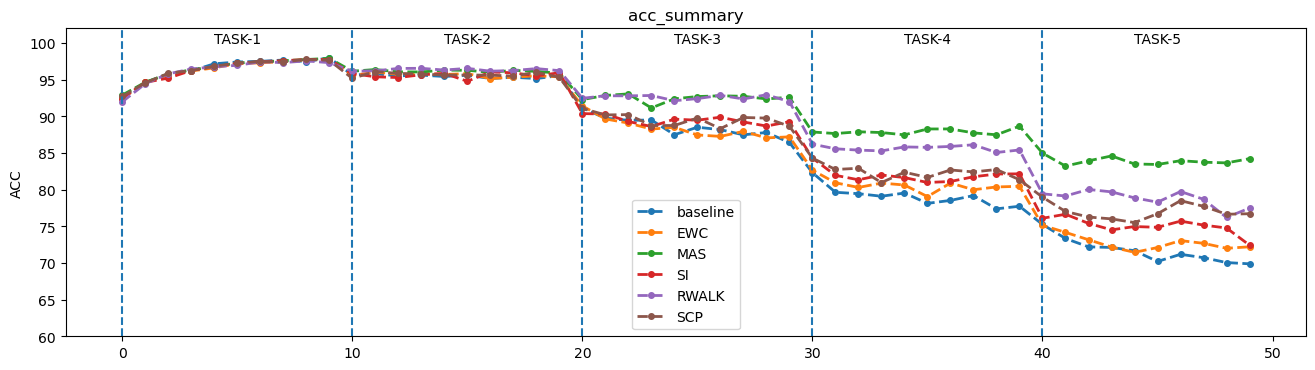

In [25]:
import matplotlib.pyplot as plt


def draw_acc(acc_list, label_list):
    plt.figure(figsize=(16, 4))
    for idx, (acc, label) in enumerate(zip(acc_list, label_list)):
        plt.plot(acc, marker='o', linestyle='--', linewidth=2, markersize=4, label=label)
        
    
    for idx, x in enumerate(range(0, len(acc_list[0]), 10)):
        plt.axvline(x=x, linestyle='--')
        plt.text(x=x+5, y=100, s=f"TASK-{idx+1}", ha='center')
    plt.savefig('acc_summary.png')
    plt.title('acc_summary')
    plt.ylim(60, 102)
    plt.ylabel('ACC')
    plt.legend()
    plt.show() 


acc_list = [baseline_acc, ewc_acc, mas_acc, si_acc, rwalk_acc, scp_acc]
label_list = ['baseline', 'EWC', 'MAS', 'SI', 'RWALK', 'SCP']
# acc_list = [  mas_acc, si_acc, rwalk_acc, scp_acc]
# label_list = [  'MAS', 'SI', 'RWALK', 'SCP']
draw_acc(acc_list, label_list)